In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import albumentations as albu
import segmentation_models as sm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
from model import ModelCreator
from datapipeline import DatasetCreator
import random
import shutil
import wandb
tf.random.set_seed(1)
random.seed(1)

Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
wandb.init(
    # set the wandb project where this run will be logged
    project="SWWH",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: denisborychev. Use `wandb login --relogin` to force relogin


In [4]:
height = 512

In [5]:
val_transforms = albu.Compose([
    albu.Resize(height, height),
    albu.Lambda(image=lambda x,**kwargs: x/255),
])

/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1777: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(


In [6]:
valdataset = DatasetCreator(val_transforms)

In [7]:
valdata = valdataset('crosval/val/*png','castom-masks/masks_machine/')
len(valdata)

8

In [8]:
trainaugmentation = albu.Compose([
    albu.Resize(height,height),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomRotate90(p=0.5),
    albu.Transpose(p=0.5),
    albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
    albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
    albu.GridDistortion(p=0.5),
    albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    albu.RandomBrightnessContrast(p=0.5),
    albu.RandomGamma(p=0.5),
    albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
    albu.GaussNoise(),
    albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
    albu.Lambda(image=lambda x,**kwargs: x/255),
    #albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],always_apply=True)
])#todo change later

In [9]:
traindataset = DatasetCreator(trainaugmentation)

In [10]:
traindata = traindataset('crosval/train/*png','castom-masks/masks_machine/')
len(traindata)

20

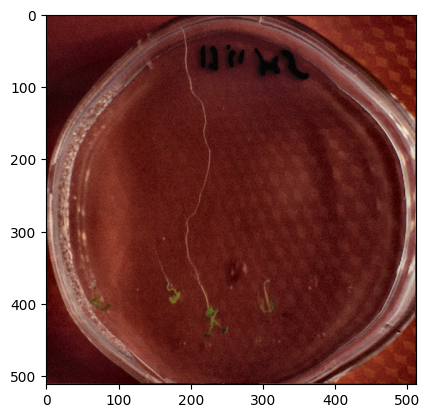

tf.Tensor(
[[[[0.3254902  0.07450981 0.08235294]
   [0.2901961  0.04705882 0.07450981]
   [0.28627452 0.05098039 0.06666667]
   ...
   [0.32941177 0.03921569 0.03529412]
   [0.2901961  0.01568628 0.00392157]
   [0.30980393 0.01568628 0.00784314]]

  [[0.30588236 0.07058824 0.08627451]
   [0.34901962 0.07450981 0.09019608]
   [0.3254902  0.07450981 0.09019608]
   ...
   [0.34117648 0.05882353 0.03137255]
   [0.3529412  0.05882353 0.03921569]
   [0.2509804  0.         0.        ]]

  [[0.3254902  0.07450981 0.08235294]
   [0.3137255  0.09019608 0.09411765]
   [0.38431373 0.10588235 0.09803922]
   ...
   [0.3019608  0.         0.01176471]
   [0.35686275 0.08627451 0.0627451 ]
   [0.2509804  0.00392157 0.        ]]

  ...

  [[0.28627452 0.0627451  0.07843138]
   [0.32941177 0.07843138 0.09803922]
   [0.3254902  0.08235294 0.09803922]
   ...
   [0.3764706  0.0627451  0.03529412]
   [0.35686275 0.01176471 0.01960784]
   [0.28627452 0.         0.        ]]

  [[0.31764707 0.09019608 0.094117

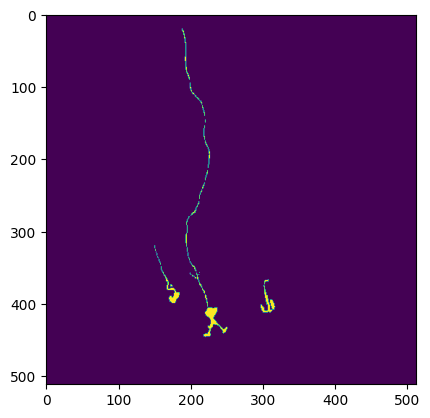

In [11]:
for image,mask in traindata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))
        print(image)

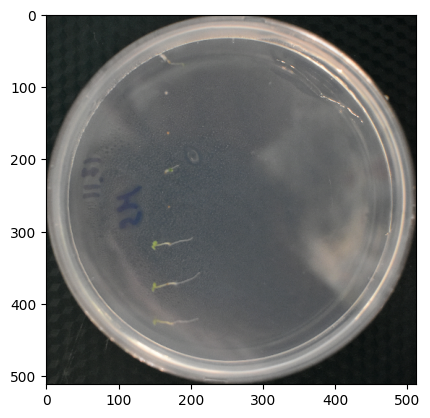

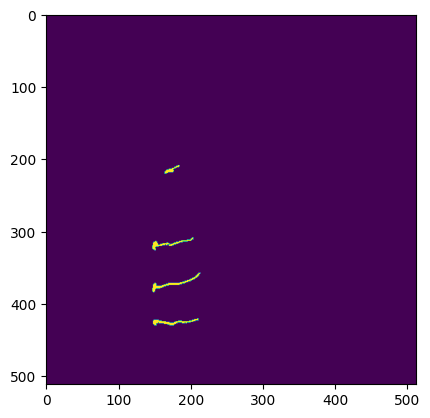

In [12]:
for image,mask in valdata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

In [13]:
modelcreator = ModelCreator()
model = modelcreator.buildmodel()
model.compile('Adam', loss=sm.losses.binary_focal_dice_loss, metrics=[sm.metrics.iou_score])

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), name='conv2d_transpose_5/Sigmoid:0', description="created by layer 'conv2d_transpose_5'")


In [14]:
#tf.keras.utils.plot_model(model)

In [15]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1) if epoch > 15 and epoch % 15 == 0 else lr

callback =[
    tf.keras.callbacks.EarlyStopping(min_delta=0.0001,patience=30,verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='bestmodel.h5',save_best_only=True,monitor='val_loss',verbose=1),
    wandb.keras.WandbMetricsLogger(log_freq=5),
    wandb.keras.WandbModelCheckpoint("models")
]

In [16]:
# fit model
model_history = model.fit(
    traindata,
    epochs=1000,
    validation_data=valdata,
    callbacks=callback,
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/1000
20/20 [==============================] - ETA: 0s - loss: 1.1893 - iou_score: 0.0091
Epoch 1: val_loss improved from inf to 1.04617, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.3s


20/20 [==============================] - 36s 1s/step - loss: 1.1893 - iou_score: 0.0091 - val_loss: 1.0462 - val_iou_score: 6.6282e-10 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/1000
20/20 [==============================] - ETA: 0s - loss: 0.9721 - iou_score: 0.0238
Epoch 2: val_loss improved from 1.04617 to 1.04292, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 36s 1s/step - loss: 0.9721 - iou_score: 0.0238 - val_loss: 1.0429 - val_iou_score: 5.2081e-10 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/1000
20/20 [==============================] - ETA: 0s - loss: 0.8966 - iou_score: 0.0683
Epoch 3: val_loss improved from 1.04292 to 1.03123, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.8966 - iou_score: 0.0683 - val_loss: 1.0312 - val_iou_score: 0.0035 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/1000
20/20 [==============================] - ETA: 0s - loss: 0.8291 - iou_score: 0.1088
Epoch 4: val_loss improved from 1.03123 to 0.89213, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.8291 - iou_score: 0.1088 - val_loss: 0.8921 - val_iou_score: 0.0657 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/1000
20/20 [==============================] - ETA: 0s - loss: 0.7538 - iou_score: 0.1542
Epoch 5: val_loss did not improve from 0.89213
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.7538 - iou_score: 0.1542 - val_loss: 0.9589 - val_iou_score: 0.0358 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 6/1000
20/20 [==============================] - ETA: 0s - loss: 0.6426 - iou_score: 0.2337
Epoch 6: val_loss improved from 0.89213 to 0.86523, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.6426 - iou_score: 0.2337 - val_loss: 0.8652 - val_iou_score: 0.0781 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 7/1000
20/20 [==============================] - ETA: 0s - loss: 0.5820 - iou_score: 0.2743
Epoch 7: val_loss improved from 0.86523 to 0.80280, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 36s 2s/step - loss: 0.5820 - iou_score: 0.2743 - val_loss: 0.8028 - val_iou_score: 0.1161 - lr: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 8/1000
20/20 [==============================] - ETA: 0s - loss: 0.5717 - iou_score: 0.2909
Epoch 8: val_loss did not improve from 0.80280
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.5717 - iou_score: 0.2909 - val_loss: 0.8561 - val_iou_score: 0.0883 - lr: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 9/1000
20/20 [==============================] - ETA: 0s - loss: 0.5502 - iou_score: 0.3104
Epoch 9: val_loss improved from 0.80280 to 0.75731, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.5502 - iou_score: 0.3104 - val_loss: 0.7573 - val_iou_score: 0.1487 - lr: 0.0010

Epoch 10: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 10/1000
20/20 [==============================] - ETA: 0s - loss: 0.5510 - iou_score: 0.3114
Epoch 10: val_loss did not improve from 0.75731
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.5510 - iou_score: 0.3114 - val_loss: 1.0132 - val_iou_score: 0.0449 - lr: 0.0010

Epoch 11: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 11/1000
20/20 [==============================] - ETA: 0s - loss: 0.5454 - iou_score: 0.3177
Epoch 11: val_loss did not improve from 0.75731
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.5454 - iou_score: 0.3177 - val_loss: 1.0688 - val_iou_score: 0.0416 - lr: 0.0010

Epoch 12: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 12/1000
20/20 [==============================] - ETA: 0s - loss: 0.6397 - iou_score: 0.2450
Epoch 12: val_loss did not improve from 0.75731
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.6397 - iou_score: 0.2450 - val_loss: 1.0839 - val_iou_score: 0.0340 - lr: 0.0010

Epoch 13: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 13/1000
20/20 [==============================] - ETA: 0s - loss: 0.5465 - iou_score: 0.3208
Epoch 13: val_loss did not improve from 0.75731
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 32s 1s/step - loss: 0.5465 - iou_score: 0.3208 - val_loss: 0.8716 - val_iou_score: 0.0942 - lr: 0.0010

Epoch 14: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 14/1000
20/20 [==============================] - ETA: 0s - loss: 0.4954 - iou_score: 0.3573
Epoch 14: val_loss improved from 0.75731 to 0.47236, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.4954 - iou_score: 0.3573 - val_loss: 0.4724 - val_iou_score: 0.3718 - lr: 0.0010

Epoch 15: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 15/1000
20/20 [==============================] - ETA: 0s - loss: 0.5019 - iou_score: 0.3543
Epoch 15: val_loss did not improve from 0.47236
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.5019 - iou_score: 0.3543 - val_loss: 0.5390 - val_iou_score: 0.3201 - lr: 0.0010

Epoch 16: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 16/1000
20/20 [==============================] - ETA: 0s - loss: 0.4927 - iou_score: 0.3567
Epoch 16: val_loss improved from 0.47236 to 0.46622, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.4927 - iou_score: 0.3567 - val_loss: 0.4662 - val_iou_score: 0.3887 - lr: 0.0010

Epoch 17: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 17/1000
20/20 [==============================] - ETA: 0s - loss: 0.5109 - iou_score: 0.3535
Epoch 17: val_loss improved from 0.46622 to 0.40662, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.5109 - iou_score: 0.3535 - val_loss: 0.4066 - val_iou_score: 0.4370 - lr: 0.0010

Epoch 18: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 18/1000
20/20 [==============================] - ETA: 0s - loss: 0.4836 - iou_score: 0.3732
Epoch 18: val_loss improved from 0.40662 to 0.38627, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 36s 2s/step - loss: 0.4836 - iou_score: 0.3732 - val_loss: 0.3863 - val_iou_score: 0.4603 - lr: 0.0010

Epoch 19: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 19/1000
20/20 [==============================] - ETA: 0s - loss: 0.4461 - iou_score: 0.3996
Epoch 19: val_loss improved from 0.38627 to 0.36996, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 38s 2s/step - loss: 0.4461 - iou_score: 0.3996 - val_loss: 0.3700 - val_iou_score: 0.4725 - lr: 0.0010

Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/1000
20/20 [==============================] - ETA: 0s - loss: 0.4592 - iou_score: 0.3855
Epoch 20: val_loss did not improve from 0.36996
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.4592 - iou_score: 0.3855 - val_loss: 0.3931 - val_iou_score: 0.4523 - lr: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 21/1000
20/20 [==============================] - ETA: 0s - loss: 0.4570 - iou_score: 0.3911
Epoch 21: val_loss did not improve from 0.36996
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.4570 - iou_score: 0.3911 - val_loss: 0.3883 - val_iou_score: 0.4605 - lr: 0.0010

Epoch 22: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 22/1000
20/20 [==============================] - ETA: 0s - loss: 0.4866 - iou_score: 0.3622
Epoch 22: val_loss improved from 0.36996 to 0.36338, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.4866 - iou_score: 0.3622 - val_loss: 0.3634 - val_iou_score: 0.4838 - lr: 0.0010

Epoch 23: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 23/1000
20/20 [==============================] - ETA: 0s - loss: 0.4461 - iou_score: 0.4045
Epoch 23: val_loss improved from 0.36338 to 0.35762, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 38s 2s/step - loss: 0.4461 - iou_score: 0.4045 - val_loss: 0.3576 - val_iou_score: 0.4891 - lr: 0.0010

Epoch 24: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 24/1000
20/20 [==============================] - ETA: 0s - loss: 0.4941 - iou_score: 0.3551
Epoch 24: val_loss improved from 0.35762 to 0.34587, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.4941 - iou_score: 0.3551 - val_loss: 0.3459 - val_iou_score: 0.5030 - lr: 0.0010

Epoch 25: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 25/1000
20/20 [==============================] - ETA: 0s - loss: 0.4603 - iou_score: 0.3919
Epoch 25: val_loss did not improve from 0.34587
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.4603 - iou_score: 0.3919 - val_loss: 0.3617 - val_iou_score: 0.4865 - lr: 0.0010

Epoch 26: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 26/1000
20/20 [==============================] - ETA: 0s - loss: 0.4639 - iou_score: 0.3847
Epoch 26: val_loss improved from 0.34587 to 0.33617, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 36s 2s/step - loss: 0.4639 - iou_score: 0.3847 - val_loss: 0.3362 - val_iou_score: 0.5129 - lr: 0.0010

Epoch 27: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 27/1000
20/20 [==============================] - ETA: 0s - loss: 0.4585 - iou_score: 0.3860
Epoch 27: val_loss did not improve from 0.33617
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.4585 - iou_score: 0.3860 - val_loss: 0.3382 - val_iou_score: 0.5160 - lr: 0.0010

Epoch 28: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 28/1000
20/20 [==============================] - ETA: 0s - loss: 0.4576 - iou_score: 0.3891
Epoch 28: val_loss improved from 0.33617 to 0.32313, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.4576 - iou_score: 0.3891 - val_loss: 0.3231 - val_iou_score: 0.5278 - lr: 0.0010

Epoch 29: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 29/1000
20/20 [==============================] - ETA: 0s - loss: 0.4892 - iou_score: 0.3672
Epoch 29: val_loss did not improve from 0.32313
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 36s 2s/step - loss: 0.4892 - iou_score: 0.3672 - val_loss: 0.3287 - val_iou_score: 0.5279 - lr: 0.0010

Epoch 30: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 30/1000
20/20 [==============================] - ETA: 0s - loss: 0.4524 - iou_score: 0.4020
Epoch 30: val_loss did not improve from 0.32313
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.4524 - iou_score: 0.4020 - val_loss: 0.3278 - val_iou_score: 0.5252 - lr: 0.0010

Epoch 31: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 31/1000
20/20 [==============================] - ETA: 0s - loss: 0.4232 - iou_score: 0.4219
Epoch 31: val_loss improved from 0.32313 to 0.31051, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 37s 2s/step - loss: 0.4232 - iou_score: 0.4219 - val_loss: 0.3105 - val_iou_score: 0.5430 - lr: 9.0484e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 32/1000
20/20 [==============================] - ETA: 0s - loss: 0.4499 - iou_score: 0.4054
Epoch 32: val_loss improved from 0.31051 to 0.29612, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.4499 - iou_score: 0.4054 - val_loss: 0.2961 - val_iou_score: 0.5656 - lr: 9.0484e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 33/1000
20/20 [==============================] - ETA: 0s - loss: 0.4026 - iou_score: 0.4399
Epoch 33: val_loss did not improve from 0.29612
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.4026 - iou_score: 0.4399 - val_loss: 0.2978 - val_iou_score: 0.5550 - lr: 9.0484e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 34/1000
20/20 [==============================] - ETA: 0s - loss: 0.4173 - iou_score: 0.4234
Epoch 34: val_loss did not improve from 0.29612
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 45s 2s/step - loss: 0.4173 - iou_score: 0.4234 - val_loss: 0.3255 - val_iou_score: 0.5348 - lr: 9.0484e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 35/1000
20/20 [==============================] - ETA: 0s - loss: 0.4272 - iou_score: 0.4213
Epoch 35: val_loss improved from 0.29612 to 0.29116, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 36s 1s/step - loss: 0.4272 - iou_score: 0.4213 - val_loss: 0.2912 - val_iou_score: 0.5680 - lr: 9.0484e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 36/1000
20/20 [==============================] - ETA: 0s - loss: 0.4343 - iou_score: 0.4191
Epoch 36: val_loss improved from 0.29116 to 0.28276, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.4343 - iou_score: 0.4191 - val_loss: 0.2828 - val_iou_score: 0.5760 - lr: 9.0484e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 37/1000
20/20 [==============================] - ETA: 0s - loss: 0.4202 - iou_score: 0.4298
Epoch 37: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.4202 - iou_score: 0.4298 - val_loss: 0.3250 - val_iou_score: 0.5261 - lr: 9.0484e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 38/1000
20/20 [==============================] - ETA: 0s - loss: 0.4514 - iou_score: 0.3995
Epoch 38: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.4514 - iou_score: 0.3995 - val_loss: 0.2943 - val_iou_score: 0.5591 - lr: 9.0484e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 39/1000
20/20 [==============================] - ETA: 0s - loss: 0.4320 - iou_score: 0.4158
Epoch 39: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.4320 - iou_score: 0.4158 - val_loss: 0.3071 - val_iou_score: 0.5451 - lr: 9.0484e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 40/1000
20/20 [==============================] - ETA: 0s - loss: 0.4033 - iou_score: 0.4436
Epoch 40: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.4033 - iou_score: 0.4436 - val_loss: 0.3019 - val_iou_score: 0.5534 - lr: 9.0484e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 41/1000
20/20 [==============================] - ETA: 0s - loss: 0.4079 - iou_score: 0.4389
Epoch 41: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.4079 - iou_score: 0.4389 - val_loss: 0.2924 - val_iou_score: 0.5636 - lr: 9.0484e-04

Epoch 42: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 42/1000
20/20 [==============================] - ETA: 0s - loss: 0.4274 - iou_score: 0.4173
Epoch 42: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.4274 - iou_score: 0.4173 - val_loss: 0.3244 - val_iou_score: 0.5291 - lr: 9.0484e-04

Epoch 43: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 43/1000
20/20 [==============================] - ETA: 0s - loss: 0.4402 - iou_score: 0.4035
Epoch 43: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 2s/step - loss: 0.4402 - iou_score: 0.4035 - val_loss: 0.3302 - val_iou_score: 0.5169 - lr: 9.0484e-04

Epoch 44: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 44/1000
20/20 [==============================] - ETA: 0s - loss: 0.4101 - iou_score: 0.4421
Epoch 44: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 36s 1s/step - loss: 0.4101 - iou_score: 0.4421 - val_loss: 0.3666 - val_iou_score: 0.4917 - lr: 9.0484e-04

Epoch 45: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 45/1000
20/20 [==============================] - ETA: 0s - loss: 0.4446 - iou_score: 0.4089
Epoch 45: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 32s 1s/step - loss: 0.4446 - iou_score: 0.4089 - val_loss: 0.3294 - val_iou_score: 0.5232 - lr: 9.0484e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 46/1000
20/20 [==============================] - ETA: 0s - loss: 0.4381 - iou_score: 0.4083
Epoch 46: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.4381 - iou_score: 0.4083 - val_loss: 0.3064 - val_iou_score: 0.5514 - lr: 8.1873e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 47/1000
20/20 [==============================] - ETA: 0s - loss: 0.4128 - iou_score: 0.4405
Epoch 47: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.4128 - iou_score: 0.4405 - val_loss: 0.3183 - val_iou_score: 0.5358 - lr: 8.1873e-04

Epoch 48: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 48/1000
20/20 [==============================] - ETA: 0s - loss: 0.4057 - iou_score: 0.4385
Epoch 48: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.4057 - iou_score: 0.4385 - val_loss: 0.3023 - val_iou_score: 0.5534 - lr: 8.1873e-04

Epoch 49: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 49/1000
20/20 [==============================] - ETA: 0s - loss: 0.4027 - iou_score: 0.4467
Epoch 49: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 36s 2s/step - loss: 0.4027 - iou_score: 0.4467 - val_loss: 0.3102 - val_iou_score: 0.5451 - lr: 8.1873e-04

Epoch 50: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 50/1000
20/20 [==============================] - ETA: 0s - loss: 0.4311 - iou_score: 0.4171
Epoch 50: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.4311 - iou_score: 0.4171 - val_loss: 0.3229 - val_iou_score: 0.5272 - lr: 8.1873e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 51/1000
20/20 [==============================] - ETA: 0s - loss: 0.4157 - iou_score: 0.4246
Epoch 51: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.4157 - iou_score: 0.4246 - val_loss: 0.2999 - val_iou_score: 0.5571 - lr: 8.1873e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 52/1000
20/20 [==============================] - ETA: 0s - loss: 0.4086 - iou_score: 0.4330
Epoch 52: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.4086 - iou_score: 0.4330 - val_loss: 0.2988 - val_iou_score: 0.5567 - lr: 8.1873e-04

Epoch 53: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 53/1000
20/20 [==============================] - ETA: 0s - loss: 0.3869 - iou_score: 0.4622
Epoch 53: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.3869 - iou_score: 0.4622 - val_loss: 0.3116 - val_iou_score: 0.5385 - lr: 8.1873e-04

Epoch 54: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 54/1000
20/20 [==============================] - ETA: 0s - loss: 0.4078 - iou_score: 0.4419
Epoch 54: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.4078 - iou_score: 0.4419 - val_loss: 0.3149 - val_iou_score: 0.5385 - lr: 8.1873e-04

Epoch 55: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 55/1000
20/20 [==============================] - ETA: 0s - loss: 0.3884 - iou_score: 0.4482
Epoch 55: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.3884 - iou_score: 0.4482 - val_loss: 0.3145 - val_iou_score: 0.5392 - lr: 8.1873e-04

Epoch 56: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 56/1000
20/20 [==============================] - ETA: 0s - loss: 0.3944 - iou_score: 0.4470
Epoch 56: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.3944 - iou_score: 0.4470 - val_loss: 0.3156 - val_iou_score: 0.5400 - lr: 8.1873e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 57/1000
20/20 [==============================] - ETA: 0s - loss: 0.4151 - iou_score: 0.4335
Epoch 57: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 56s 3s/step - loss: 0.4151 - iou_score: 0.4335 - val_loss: 0.3186 - val_iou_score: 0.5351 - lr: 8.1873e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 58/1000
20/20 [==============================] - ETA: 0s - loss: 0.3974 - iou_score: 0.4498
Epoch 58: val_loss did not improve from 0.28276
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 38s 2s/step - loss: 0.3974 - iou_score: 0.4498 - val_loss: 0.3093 - val_iou_score: 0.5466 - lr: 8.1873e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 59/1000
20/20 [==============================] - ETA: 0s - loss: 0.4015 - iou_score: 0.4496
Epoch 59: val_loss improved from 0.28276 to 0.26580, saving model to bestmodel.h5


/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.4015 - iou_score: 0.4496 - val_loss: 0.2658 - val_iou_score: 0.5999 - lr: 8.1873e-04

Epoch 60: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 60/1000
20/20 [==============================] - ETA: 0s - loss: 0.4089 - iou_score: 0.4333
Epoch 60: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 36s 2s/step - loss: 0.4089 - iou_score: 0.4333 - val_loss: 0.2838 - val_iou_score: 0.5767 - lr: 8.1873e-04

Epoch 61: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 61/1000
20/20 [==============================] - ETA: 0s - loss: 0.3954 - iou_score: 0.4505
Epoch 61: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.3954 - iou_score: 0.4505 - val_loss: 0.2889 - val_iou_score: 0.5717 - lr: 7.4082e-04

Epoch 62: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 62/1000
20/20 [==============================] - ETA: 0s - loss: 0.4071 - iou_score: 0.4373
Epoch 62: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 36s 1s/step - loss: 0.4071 - iou_score: 0.4373 - val_loss: 0.2913 - val_iou_score: 0.5679 - lr: 7.4082e-04

Epoch 63: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 63/1000
20/20 [==============================] - ETA: 0s - loss: 0.4235 - iou_score: 0.4247
Epoch 63: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 37s 2s/step - loss: 0.4235 - iou_score: 0.4247 - val_loss: 0.2856 - val_iou_score: 0.5720 - lr: 7.4082e-04

Epoch 64: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 64/1000
20/20 [==============================] - ETA: 0s - loss: 0.3759 - iou_score: 0.4655
Epoch 64: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.3759 - iou_score: 0.4655 - val_loss: 0.2847 - val_iou_score: 0.5758 - lr: 7.4082e-04

Epoch 65: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 65/1000
20/20 [==============================] - ETA: 0s - loss: 0.4078 - iou_score: 0.4286
Epoch 65: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.4078 - iou_score: 0.4286 - val_loss: 0.2897 - val_iou_score: 0.5678 - lr: 7.4082e-04

Epoch 66: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 66/1000
20/20 [==============================] - ETA: 0s - loss: 0.3967 - iou_score: 0.4455
Epoch 66: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.3967 - iou_score: 0.4455 - val_loss: 0.2817 - val_iou_score: 0.5796 - lr: 7.4082e-04

Epoch 67: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 67/1000
20/20 [==============================] - ETA: 0s - loss: 0.3985 - iou_score: 0.4424
Epoch 67: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.3985 - iou_score: 0.4424 - val_loss: 0.3372 - val_iou_score: 0.5162 - lr: 7.4082e-04

Epoch 68: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 68/1000
20/20 [==============================] - ETA: 0s - loss: 0.4071 - iou_score: 0.4406
Epoch 68: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 36s 2s/step - loss: 0.4071 - iou_score: 0.4406 - val_loss: 0.2889 - val_iou_score: 0.5660 - lr: 7.4082e-04

Epoch 69: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 69/1000
20/20 [==============================] - ETA: 0s - loss: 0.4151 - iou_score: 0.4297
Epoch 69: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 60s 3s/step - loss: 0.4151 - iou_score: 0.4297 - val_loss: 0.3201 - val_iou_score: 0.5305 - lr: 7.4082e-04

Epoch 70: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 70/1000
20/20 [==============================] - ETA: 0s - loss: 0.3771 - iou_score: 0.4690
Epoch 70: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 37s 1s/step - loss: 0.3771 - iou_score: 0.4690 - val_loss: 0.2964 - val_iou_score: 0.5610 - lr: 7.4082e-04

Epoch 71: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 71/1000
20/20 [==============================] - ETA: 0s - loss: 0.3798 - iou_score: 0.4683
Epoch 71: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.3798 - iou_score: 0.4683 - val_loss: 0.2804 - val_iou_score: 0.5789 - lr: 7.4082e-04

Epoch 72: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 72/1000
20/20 [==============================] - ETA: 0s - loss: 0.3718 - iou_score: 0.4695
Epoch 72: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.3718 - iou_score: 0.4695 - val_loss: 0.2835 - val_iou_score: 0.5758 - lr: 7.4082e-04

Epoch 73: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 73/1000
20/20 [==============================] - ETA: 0s - loss: 0.3975 - iou_score: 0.4471
Epoch 73: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 38s 2s/step - loss: 0.3975 - iou_score: 0.4471 - val_loss: 0.2775 - val_iou_score: 0.5800 - lr: 7.4082e-04

Epoch 74: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 74/1000
20/20 [==============================] - ETA: 0s - loss: 0.3822 - iou_score: 0.4629
Epoch 74: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.3822 - iou_score: 0.4629 - val_loss: 0.2844 - val_iou_score: 0.5741 - lr: 7.4082e-04

Epoch 75: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 75/1000
20/20 [==============================] - ETA: 0s - loss: 0.3857 - iou_score: 0.4686
Epoch 75: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 33s 1s/step - loss: 0.3857 - iou_score: 0.4686 - val_loss: 0.2950 - val_iou_score: 0.5623 - lr: 7.4082e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 76/1000
20/20 [==============================] - ETA: 0s - loss: 0.4005 - iou_score: 0.4478
Epoch 76: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 32s 1s/step - loss: 0.4005 - iou_score: 0.4478 - val_loss: 0.2949 - val_iou_score: 0.5643 - lr: 6.7032e-04

Epoch 77: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 77/1000
20/20 [==============================] - ETA: 0s - loss: 0.4007 - iou_score: 0.4474
Epoch 77: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.4007 - iou_score: 0.4474 - val_loss: 0.2813 - val_iou_score: 0.5809 - lr: 6.7032e-04

Epoch 78: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 78/1000
20/20 [==============================] - ETA: 0s - loss: 0.4101 - iou_score: 0.4417
Epoch 78: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.4101 - iou_score: 0.4417 - val_loss: 0.2841 - val_iou_score: 0.5732 - lr: 6.7032e-04

Epoch 79: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 79/1000
20/20 [==============================] - ETA: 0s - loss: 0.3746 - iou_score: 0.4719
Epoch 79: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 37s 2s/step - loss: 0.3746 - iou_score: 0.4719 - val_loss: 0.2718 - val_iou_score: 0.5928 - lr: 6.7032e-04

Epoch 80: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 80/1000
20/20 [==============================] - ETA: 0s - loss: 0.4032 - iou_score: 0.4372
Epoch 80: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.4032 - iou_score: 0.4372 - val_loss: 0.2873 - val_iou_score: 0.5727 - lr: 6.7032e-04

Epoch 81: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 81/1000
20/20 [==============================] - ETA: 0s - loss: 0.3684 - iou_score: 0.4735
Epoch 81: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 44s 2s/step - loss: 0.3684 - iou_score: 0.4735 - val_loss: 0.2691 - val_iou_score: 0.5906 - lr: 6.7032e-04

Epoch 82: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 82/1000
20/20 [==============================] - ETA: 0s - loss: 0.3916 - iou_score: 0.4596
Epoch 82: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 38s 2s/step - loss: 0.3916 - iou_score: 0.4596 - val_loss: 0.2707 - val_iou_score: 0.5906 - lr: 6.7032e-04

Epoch 83: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 83/1000
20/20 [==============================] - ETA: 0s - loss: 0.4065 - iou_score: 0.4426
Epoch 83: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 37s 2s/step - loss: 0.4065 - iou_score: 0.4426 - val_loss: 0.2981 - val_iou_score: 0.5627 - lr: 6.7032e-04

Epoch 84: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 84/1000
20/20 [==============================] - ETA: 0s - loss: 0.3830 - iou_score: 0.4622
Epoch 84: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 38s 2s/step - loss: 0.3830 - iou_score: 0.4622 - val_loss: 0.2888 - val_iou_score: 0.5713 - lr: 6.7032e-04

Epoch 85: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 85/1000
20/20 [==============================] - ETA: 0s - loss: 0.3936 - iou_score: 0.4588
Epoch 85: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 40s 2s/step - loss: 0.3936 - iou_score: 0.4588 - val_loss: 0.2737 - val_iou_score: 0.5884 - lr: 6.7032e-04

Epoch 86: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 86/1000
20/20 [==============================] - ETA: 0s - loss: 0.4001 - iou_score: 0.4443
Epoch 86: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 35s 1s/step - loss: 0.4001 - iou_score: 0.4443 - val_loss: 0.2886 - val_iou_score: 0.5690 - lr: 6.7032e-04

Epoch 87: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 87/1000
20/20 [==============================] - ETA: 0s - loss: 0.3799 - iou_score: 0.4713
Epoch 87: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.3799 - iou_score: 0.4713 - val_loss: 0.2917 - val_iou_score: 0.5640 - lr: 6.7032e-04

Epoch 88: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 88/1000
20/20 [==============================] - ETA: 0s - loss: 0.3821 - iou_score: 0.4620
Epoch 88: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.3821 - iou_score: 0.4620 - val_loss: 0.3051 - val_iou_score: 0.5516 - lr: 6.7032e-04

Epoch 89: LearningRateScheduler setting learning rate to 0.0006703201215714216.
Epoch 89/1000
20/20 [==============================] - ETA: 0s - loss: 0.3661 - iou_score: 0.4795
Epoch 89: val_loss did not improve from 0.26580
INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.2s


20/20 [==============================] - 34s 1s/step - loss: 0.3661 - iou_score: 0.4795 - val_loss: 0.2888 - val_iou_score: 0.5705 - lr: 6.7032e-04
Epoch 89: early stopping


In [17]:
testdata = valdataset('crosval/test/*png','castom-masks/masks_machine/',batch_size=1)

In [18]:
results = model.evaluate(testdata)
results

10/10 [==============================] - 2s 91ms/step - loss: 0.3127 - iou_score: 0.5552


[0.31271857023239136, 0.5552196502685547]

[0.3014904856681824, 0.5658320784568787]

In [19]:
i = 0

if os.path.isdir('output/'):
    shutil.rmtree('output/')
os.makedirs('output/')

for image,truemask in testdata.take(len(testdata)):
    mask = model.predict((tf.reshape(image,[1,height,height,3])))
    mask = tf.keras.utils.array_to_img(mask[0])
    img = tf.keras.utils.array_to_img(image[0])
    img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
    vis = np.concatenate((img, mask), axis=1)
    i+=1
    cv2.imwrite('output/'+str(i)+'.png', vis)

1/1 [==============================] - 0s 85ms/step
